<a href="https://colab.research.google.com/github/AbhilashDatta/LITS/blob/main/Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOUNTING DRIVE

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# IMPORTING LIBRARIES

In [3]:
!pip install medpy --upgrade --q
!pip install nibabel --upgrade --q
!pip install nilearn --upgrade --q
!pip install torchio --upgrade --q

     |████████████████████████████████| 151 kB 4.1 MB/s 
     |████████████████████████████████| 48.4 MB 8.2 kB/s 
     |████████████████████████████████| 3.3 MB 4.2 MB/s 
     |████████████████████████████████| 10.0 MB 3.8 MB/s 
     |████████████████████████████████| 156 kB 4.1 MB/s 


In [4]:
import os
import torch
from glob import glob
import nibabel as nib
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from tqdm import tqdm
import enum
from skimage.transform import resize
import time
from scipy import stats
import random
from IPython import display
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import torchvision
import torchio as tio

# GAN 

In [5]:
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from skimage.transform import resize
  
class Generator(nn.Module):
    def __init__(self, noise:int=1000, channel:int=64):
        super(Generator, self).__init__()
        _c = channel
        
        self.noise = noise
        self.fc = nn.Linear(1000,512*4*4*4)
        self.bn1 = nn.BatchNorm3d(_c*8)
        
        self.tp_conv2 = nn.Conv3d(_c*8, _c*4, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(_c*4)
        
        self.tp_conv3 = nn.Conv3d(_c*4, _c*2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm3d(_c*2)
        
        self.tp_conv4 = nn.Conv3d(_c*2, _c, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm3d(_c)
        
        self.tp_conv5 = nn.Conv3d(_c, 1, kernel_size=3, stride=1, padding=1, bias=False)
        
    def forward(self, noise):
        noise = noise.view(-1, 1000)
        h = self.fc(noise)
        h = h.view(-1,512,4,4,4)
        h = F.relu(self.bn1(h))

        h = F.interpolate(h,scale_factor = 2)
        h = self.tp_conv2(h)
        h = F.relu(self.bn2(h))
        
        h = F.interpolate(h,scale_factor = 2)
        h = self.tp_conv3(h)
        h = F.relu(self.bn3(h))

        h = F.interpolate(h,scale_factor = 2)
        h = self.tp_conv4(h)
        h = F.relu(self.bn4(h))

        h = F.interpolate(h,scale_factor = 2)
        h = self.tp_conv5(h)
        
        h = torch.tanh(h)

        # Extra layers
        h = F.interpolate(h,scale_factor = 2)

        return h

In [6]:
# Loading Generator

G = Generator().cuda()
G.load_state_dict(torch.load('/content/gdrive/MyDrive/WGAN_G.pth',map_location='cuda:0'))


<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


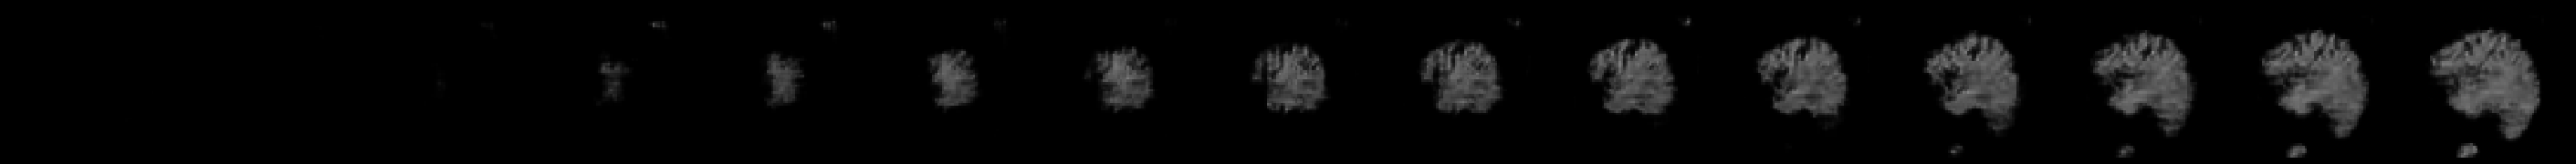

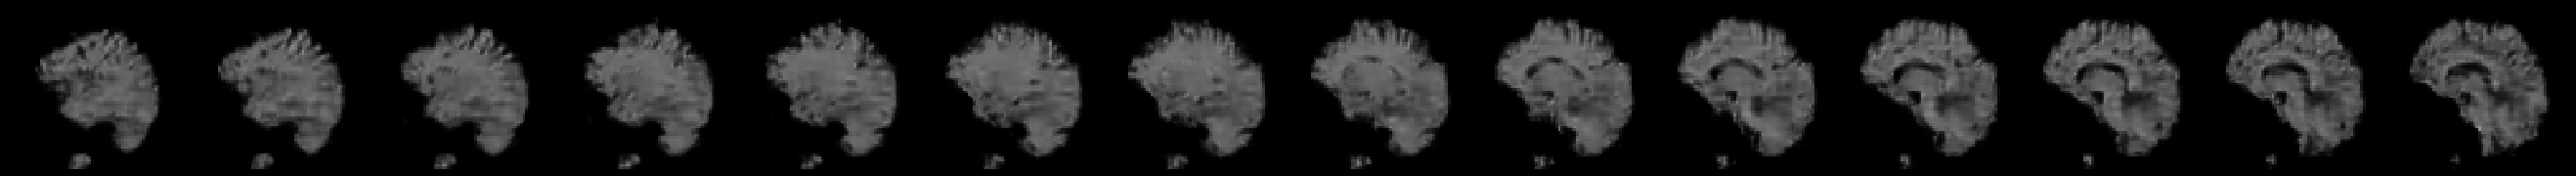

In [7]:
import nibabel as nib
from nilearn import plotting

Show_color = False

noise = Variable(torch.randn((1, 1000)).cuda())
fake_image = G(noise)
featmask = np.squeeze(fake_image[0].data.cpu().numpy())
featmask = nib.Nifti1Image(featmask,affine = np.eye(4))

arr1 = [4,6,8,10,12,14,16,18,20,22,24,26,28,30,32]
arr2 = [34,36,38,40,42,44,46,48,50,52,54,56,58,60]
if Show_color:
    disp = plotting.plot_img(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False,positions=True)
    plotting.show()
    disp=plotting.plot_img(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()
else:
    disp = plotting.plot_anat(featmask,cut_coords=arr1,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    plotting.show()
    # disp.annotate(size=25,left_right=False)
    disp=plotting.plot_anat(featmask,cut_coords=arr2,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
    # disp.annotate(size=25,left_right=False)
    plotting.show()

In [8]:
# visualization
import matplotlib.pyplot as plt

def show_image(test_image):
    count = 1
    # test_image = test_image.view(64*2,64*2,64*2)
    test_image = test_image.detach().to('cpu')
    plt.figure(figsize=(20,12))
    for i in range(48):
        # if i%2==0:
            plt.subplot(8,6,count)
            count+=1
            # plt.imshow(test_image[:,:,i])
            plt.imshow(test_image[:,:,i], cmap='bone')
    plt.show()
    # plt.savefig('brain_48.png')
    
    

# noise = Variable(torch.randn((1, 1000, 1, 1 ,1)).cuda())

# fake_image = G(noise)
# print(fake_image.shape)
# show_image(fake_image[0])

# UNET

In [8]:
class Attention(nn.Module):   #it gives channel attention
    def __init__(self, in_channels, reduced_dim):  #input_shape ---> output_shape
        super(Attention, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1), # C x H x W -> C x 1 x 1
            nn.Conv3d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv3d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer

def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d

def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)

def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d

def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)

def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d

def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)

def get_activation(activation: str):
    if activation == 'ReLU':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()
    elif activation == 'PReLU':
        return nn.PReLU()

def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)

class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x

class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
        
        self.Attention = Attention(self.out_channels,16)
        # self.ProjectExciteLayer = ProjectExciteLayer(self.out_channels)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        
        y = self.Attention(y)
        # y = self.ProjectExciteLayer(y)

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling

class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


In [9]:
class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.kaiming_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

In [10]:
segmentor = UNet(in_channels=3,
             out_channels=4,
             n_blocks=4,
             start_filters=32,
             activation='ReLU',
             normalization='batch',
             conv_mode='same',
             dim=3).to('cuda')
optimizer = torch.optim.Adam(segmentor.parameters(), lr=0.0001)

In [11]:
checkpoint = torch.load('/content/gdrive/MyDrive/weights_best_one.pth')
segmentor.load_state_dict(checkpoint['weights'])

<All keys matched successfully>

# DATA

In [12]:
TRAIN_IMG_DIR = "/content/gdrive/MyDrive/brain/Task01_BrainTumour/imagesTr" 
TRAIN_MASK_DIR = "/content/gdrive/MyDrive/brain/Task01_BrainTumour/labelsTr"
VAL_IMG_DIR = "/content/gdrive/MyDrive/brain/Task01_BrainTumour/imagesVal"
VAL_MASK_DIR = "/content/gdrive/MyDrive/brain/Task01_BrainTumour/labelsVal" 
TEST_IMG_DIR = "/content/gdrive/MyDrive/brain/Task01_BrainTumour/imagesTs" 

In [13]:
def make_list(s):
  l = sorted(os.listdir(s))
  return l

In [14]:
images_train = make_list(TRAIN_IMG_DIR)
masks_train = make_list(TRAIN_MASK_DIR)
images_val = make_list(VAL_IMG_DIR)
masks_val = make_list(VAL_MASK_DIR)
images_test = make_list(TEST_IMG_DIR)
len(images_train), len(masks_train), len(images_val), len(masks_val), len(images_test)

(434, 434, 50, 50, 265)

In [15]:
#list of img and mask path......TRAIN
img_train_paths = []
mask_train_paths = []
#list of img and mask path......VAL
img_val_paths = []
mask_val_paths = []
#list of img path.......TEST
img_test_paths = []

for idx in range(len(images_train)):
  img_train_paths.append(os.path.join(TRAIN_IMG_DIR, images_train[idx]))
  mask_train_paths.append(os.path.join(TRAIN_MASK_DIR, masks_train[idx]))

for idx in range(len(images_val)):
  img_val_paths.append(os.path.join(VAL_IMG_DIR, images_val[idx]))
  mask_val_paths.append(os.path.join(VAL_MASK_DIR, masks_val[idx]))

for idx in range(len(images_test)):
  img_test_paths.append(os.path.join(TEST_IMG_DIR, images_test[idx]))

len(img_train_paths), len(mask_train_paths), len(img_val_paths), len(mask_val_paths), len(img_test_paths)

(434, 434, 50, 50, 265)

In [16]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader

class TrueDataset(Dataset):
  def __init__(self, img_paths=None, mask_paths=None, transform_imgs=None, transform_mask=None):
    self.img_paths = img_paths
    self.mask_paths = mask_paths
    self.transform_imgs = transform_imgs
    self.transform_mask = transform_mask
    if self.mask_paths is not None:
      assert len(self.img_paths) == len(self.mask_paths)
    self.images = len(self.img_paths) #list all the files present in that folder...
  
  def __len__(self):
    return len(self.img_paths) #length of dataset
  
  def __getitem__(self, index):
    img_path = self.img_paths[index]
    image = nib.load(img_path).get_fdata(dtype=np.float32)
    scaler = MinMaxScaler()
    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    image = image[56:184, 56:184, 73:121]
    image0 = image[:,:,:,0]
    image2 = image[:,:,:,2]
    image3 = image[:,:,:,3]
    image = np.stack((image0,image2,image3),axis=3)

    if self.mask_paths is not None:
      mask_path = self.mask_paths[index]
      mask = nib.load(mask_path).get_fdata(dtype=np.float32)
      mask = mask.astype(np.uint8)
      mask = mask[56:184, 56:184, 73:121]
      mask = to_categorical(mask, num_classes=4)

    # image = np.load(img_path)
    image = torch.from_numpy(image)
    image = image.permute(3,0,1,2)

    if self.mask_paths is not None:
      # mask = np.load(mask_path)
      mask = torch.from_numpy(mask)
      mask = mask.permute(3,0,1,2)
 
    if self.transform_imgs is not None:
      image = training_transforms(image)
    if self.transform_mask is not None:
      mask = training_transforms(mask)
    
    if self.mask_paths is not None:
      return image, mask
    if self.mask_paths is None:
      return image

In [59]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from torch.autograd import Variable

class GeneratedDataset(Dataset):
  def __init__(self, generator, segmentor):
    self.segmentor = segmentor
    self.generator = generator

  def __len__(self):
    return 10   #length of dataset
  
  def __getitem__(self, index):
        torch.manual_seed(index)
        noise = Variable(torch.randn((1, 1000, 1, 1 ,1)).cuda())
        fake_image = self.generator(noise)
        fake_image = fake_image.view(64*2,64*2,64*2)
        fake_image = fake_image.detach().to('cpu')

        scaler = MinMaxScaler()
        fake_image = scaler.fit_transform(fake_image.reshape(-1, fake_image.shape[-1])).reshape(fake_image.shape)

        r = range(16,112,2)
        image0 = fake_image[:,:,r]
        r = range(17,112,2)
        image2 = fake_image[:,:,r]
        r = range(16,112,2)
        image3 = fake_image[:,:,r]

        image = np.stack((image0,image2,image3),axis=3)
        image = torch.from_numpy(image)
        image = image.type(torch.float32)
        image = image.permute(3,0,1,2)
        img = image.view(1,3, 128, 128, 48).to('cuda')
        
        mask = self.segmentor(img).softmax(dim=1)        
        mask = mask.view(4,128,128,48)

        return image, mask
        

# FEDERATED PIPELINE

In [73]:
# Client 1

Client_1 = dict()

Client_1['datasource_1'] = TrueDataset(
        img_paths=img_train_paths,
        mask_paths=mask_train_paths
    )

Client_1['dataloader_1'] = DataLoader(
        Client_1['datasource_1'],
        batch_size=4,
        num_workers=2,
        shuffle=True,
    )

Client_1['datasource_2'] = GeneratedDataset(
        generator = G,
        segmentor = segmentor,
    )

Client_1['dataloader_2'] = DataLoader(
        Client_1['datasource_2'],
        batch_size=1,
        num_workers=0,
        shuffle=True,
    )

Client_1['model'] = UNet(in_channels=3,
                    out_channels=4,
                    n_blocks=4,
                    start_filters=32,
                    activation='ReLU',
                    normalization='batch',
                    conv_mode='same',
                    dim=3).to('cuda')

Client_1['optimizer'] = torch.optim.Adam(Client_1['model'].parameters(), lr=0.0001)
checkpoint = torch.load('/content/gdrive/MyDrive/weights_best_one.pth')
Client_1['model'].load_state_dict(checkpoint['weights'])

# Client 2
Client_2 = dict()

Client_2['datasource_1'] = TrueDataset(
        img_paths=img_train_paths,
        mask_paths=mask_train_paths
    )

Client_2['dataloader_1'] = DataLoader(
        Client_2['datasource_1'],
        batch_size=4,
        num_workers=2,
        shuffle=True,
    )

Client_2['datasource_2'] = GeneratedDataset(
        generator = G,
        segmentor = segmentor,
    )

Client_2['dataloader_2'] = DataLoader(
        Client_2['datasource_2'],
        batch_size=1,
        num_workers=0,
        shuffle=True,
    )

Client_2['model'] = UNet(in_channels=3,
                    out_channels=4,
                    n_blocks=4,
                    start_filters=32,
                    activation='ReLU',
                    normalization='batch',
                    conv_mode='same',
                    dim=3).to('cuda')

Client_2['optimizer'] = torch.optim.Adam(Client_2['model'].parameters(), lr=0.0001)
checkpoint = torch.load('/content/gdrive/MyDrive/weights_best_one.pth')
Client_2['model'].load_state_dict(checkpoint['weights'])


<All keys matched successfully>

In [74]:
Clients = [Client_1, Client_2]

In [75]:
# Server

Server = dict()

Server['model'] = UNet(in_channels=3,
                    out_channels=4,
                    n_blocks=4,
                    start_filters=32,
                    activation='ReLU',
                    normalization='batch',
                    conv_mode='same',
                    dim=3).to('cuda')

Server['optimizer'] = torch.optim.Adam(Server['model'].parameters(), lr=0.0001)
checkpoint = torch.load('/content/gdrive/MyDrive/weights_best_one.pth')
Server['model'].load_state_dict(checkpoint['weights'])



<All keys matched successfully>

In [76]:
# Loss Function
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
 
    def forward(self, inputs, targets, smooth=1):        
        
        # inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice, dice

DiceLoss = DiceLoss()


ALPHA = 0.8
BETA = 0.2
GAMMA = 0.75

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)       
        
        c,d = DiceLoss(inputs, targets)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky, d

FocalTverskyLoss = FocalTverskyLoss()

In [77]:
# Federated Training loop

from tqdm.auto import tqdm
import torch.distributions as tdist

for epoch in range(2):
    print('\nEpoch:',epoch+1,'\n')

    i = 1
    for client in Clients:
        print(f'Training Client {i}')
        model = client['model']
        optimizer = client['optimizer']
        epoch_losses = []
        dice_coefs = []

        # Real Data
        for batch_idx, (inputs, targets) in enumerate(tqdm(client['dataloader_1'])):
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                logits = model(inputs)
                probabilities = F.softmax(logits, dim=1) 
                batch_losses, dice_coefficients = FocalTverskyLoss(probabilities, targets) #DiceLoss(probabilities, targets) 
                batch_loss = batch_losses.mean()
                dice_coef = dice_coefficients.mean()
                batch_loss.backward()
                optimizer.step()               
                epoch_losses.append(batch_loss.detach().item())
                dice_coefs.append(dice_coef.item())

        # GAN Generated Data
        for batch_idx, (inputs, targets) in enumerate(tqdm(client['dataloader_2'])):
            inputs = inputs.to('cuda')
            targets = targets.to('cuda')
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                logits = model(inputs)
                probabilities = F.softmax(logits, dim=1) 
                batch_losses, dice_coefficients = FocalTverskyLoss(probabilities, targets) #DiceLoss(probabilities, targets) 
                batch_loss = batch_losses.mean()
                dice_coef = dice_coefficients.mean()
                batch_loss.backward()
                optimizer.step()               
                epoch_losses.append(batch_loss.detach().item())
                dice_coefs.append(dice_coef.item())

        epoch_losses = np.array(epoch_losses)
        dice_coefs = np.array(dice_coefs)

        print(f'Mean loss: {epoch_losses.mean():0.3f} \t Dice score: {dice_coefs.mean():0.3f}\n')
        i+=1

    print('\nSending Weights to Central Server...\n')

    # Updating Server
    model = Server['model']
    models = [Client_1['model'], Client_2['model']]

    with torch.no_grad():
        for key in model.state_dict().keys():
            if models[0].state_dict()[key].dtype == torch.int64:
                model.state_dict()[key].data.copy_(models[0].state_dict()[key])
            else:
                temp = torch.zeros_like(model.state_dict()[key])
                # add noise
                for s in range(len(models)):
                    n = tdist.Normal(0,1)
                    noise = n.sample(models[s].state_dict()[key].size()).squeeze()
                    noise = noise.to('cuda')
                    noise = noise.view(models[s].state_dict()[key].shape)
                    temp += 0.5*(models[s].state_dict()[key] + noise*1e-5)

                # update server model
                model.state_dict()[key].data.copy_(temp)
                
                # updata client model
                for s in range(len(models)):
                    models[s].state_dict()[key].data.copy_(model.state_dict()[key])
    
    print('Central Server Updated...\n')
    print('Local Clients Updated...\n')



Epoch: 1 

Training Client 1


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Mean loss: 0.087 	 Dice score: 0.961

Training Client 2


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Mean loss: 0.089 	 Dice score: 0.959


Sending Weights to Central Server...

Central Server Updated...

Local Clients Updated...


Epoch: 2 

Training Client 1


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Mean loss: 0.090 	 Dice score: 0.958

Training Client 2


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Mean loss: 0.086 	 Dice score: 0.962


Sending Weights to Central Server...

Central Server Updated...

Local Clients Updated...



# INFERENCE

In [78]:
val_ds = TrueDataset(
        img_paths = img_val_paths,
        mask_paths = mask_val_paths
    )

val_loader = DataLoader(
        val_ds,
        batch_size=4,
        num_workers=2,
        shuffle=False,
    )


In [79]:
model = Server['model']
# model = segmentor
model.eval()
with torch.no_grad():
    for batch_idx, (inputs,outputs) in enumerate(tqdm(val_loader)):
        inputs = inputs.to('cuda')
        outputs = outputs.to('cuda')
        logits = model(inputs).softmax(dim=1)


  0%|          | 0/13 [00:00<?, ?it/s]

In [80]:
l = logits.cpu()
l = np.argmax(l, axis=1)
i = inputs.cpu()
o = outputs.cpu()
o = np.argmax(o, axis=1)

32 0


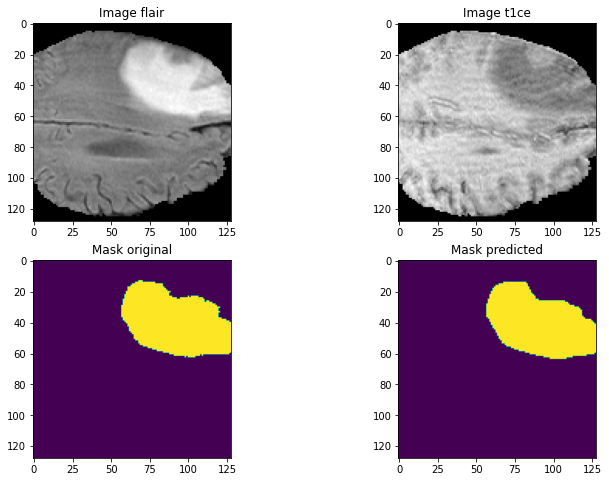

In [82]:
n_slice=random.randint(0, o.shape[3])
plt.figure(figsize=(12, 8))
no=0
print(n_slice,no)

plt.subplot(221)
plt.imshow(i[no,0,:,:, n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(i[no,1,:,:, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(o[no,:,:,n_slice])
plt.title('Mask original')
plt.subplot(224)
plt.imshow(l[no,:,:,n_slice])
plt.title('Mask predicted')
plt.show()